<a href="https://colab.research.google.com/github/Adi26Datta/Stock-Sentiment-Analysis/blob/main/StockSentiment_Adi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=06ce5553be04893fdfd3539bd6fcfac62ec7ffd2199990543534cbc0a42c763c
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
from ta.momentum import RSIIndicator

In [4]:
import pandas as pd
import yfinance as yf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import spacy
import numpy as np
#nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation


import requests
def extract_data(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        api_data = data['response']['docs']
        return api_data
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

In [ ]:
import time

for year in range(2010, 2020):
    for month in range(1, 13):
        print(f"Fetching data for {year}-{month}")
        try:
            api_data = extract_data(year, month, api_key)
            if api_data:
                all_headlines.extend([data['headline']['main'] for data in api_data])
                all_datetime.extend([data['pub_date'] for data in api_data])
            time.sleep(6)  # Wait 6 seconds before the next request
        except Exception as e:
            print(f"Failed to fetch data for {year}-{month}: {e}")
            time.sleep(10)  # Wait longer after an error

Fetching data for 2010-1
Fetching data for 2010-2
Fetching data for 2010-3
Fetching data for 2010-4
Fetching data for 2010-5
Fetching data for 2010-6
Failed to fetch data for 2010-6: 429
Fetching data for 2010-7
Fetching data for 2010-8
Fetching data for 2010-9
Fetching data for 2010-10
Fetching data for 2010-11
Fetching data for 2010-12
Failed to fetch data for 2010-12: 429
Fetching data for 2011-1
Failed to fetch data for 2011-1: 429
Fetching data for 2011-2
Failed to fetch data for 2011-2: 429
Fetching data for 2011-3
Fetching data for 2011-4
Fetching data for 2011-5
Fetching data for 2011-6
Fetching data for 2011-7
Fetching data for 2011-8
Failed to fetch data for 2011-8: 429
Fetching data for 2011-9
Failed to fetch data for 2011-9: 429
Fetching data for 2011-10
Fetching data for 2011-11
Fetching data for 2011-12
Fetching data for 2012-1
Fetching data for 2012-2
Fetching data for 2012-3
Failed to fetch data for 2012-3: 429
Fetching data for 2012-4
Failed to fetch data for 2012-4: 4

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date
df.head()

,Datetime,Headlines,date
0,2010-01-01 00:04:53+00:00,"A Camera and an Eye, Both One of a Kind",2010-01-01
1,2010-01-01 00:18:05+00:00,Looking Ahead: Dance,2010-01-01
2,2010-01-01 00:23:36+00:00,Chronicle of a Changing City,2010-01-01
3,2010-01-01 00:24:25+00:00,Chick-fil-A Bowl: No. 11 Virginia Tech (9-3) v...,2010-01-01
4,2010-01-01 00:38:34+00:00,A Taxing Estate,2010-01-01


In [ ]:
def contains_keywords(text):
    for keyword in keywords:
        if keyword.lower() in text.lower():
            return True
    return False
keywords = [
    # Company & Products
    'Facebook', 'Meta', 'Mark Zuckerberg', 'Instagram', 'Whatsapp', 'Oculus', 'Threads', 'MetaVerse',

    # Financial/Stock-Related Keywords (company-specific)
    'Meta stock', 'Facebook stock', 'stock price', 'share price', 'shares of Meta',
    'shares of Facebook', 'Meta shares', 'Facebook shares', 'Meta earnings', 'Facebook earnings',
    'Meta revenue', 'Facebook revenue', 'Meta profit', 'Facebook profit', 'earnings report',
    'earnings call', 'quarterly earnings', 'investors in Meta', 'Meta Q1', 'Meta Q2',
    'Meta Q3', 'Meta Q4', 'Meta Inc', 'NASDAQ:FB', 'NASDAQ:META',

    # Regulatory & Legal (still relevant to stock)
    'FTC investigation', 'Congress', 'Cambridge Analytica', 'GDPR', 'antitrust',

    # Security & Privacy Events
    'data breach', 'cybersecurity', 'user privacy', 'hacking'
]


df['contains_keywords'] = df['Headlines'].apply(contains_keywords)

In [ ]:
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
filtered_df.head()

,date,Headlines
0,2010-01-04,F.C.C. Chairman Spams Facebook Friends
1,2010-01-04,Congress Examines N.F.L. Concussions
2,2010-01-06,Cadbury Stock Price Draws Closer to Kraft’s Bid
3,2010-01-07,Viewing Facebook via Roku
4,2010-01-07,Antitrust Case Has Implications Far Beyond N.F.L.


In [ ]:
facebook_news1=filtered_df.copy()
facebook_news1

,date,Headlines
0,2010-01-04,F.C.C. Chairman Spams Facebook Friends
1,2010-01-04,Congress Examines N.F.L. Concussions
2,2010-01-06,Cadbury Stock Price Draws Closer to Kraft’s Bid
3,2010-01-07,Viewing Facebook via Roku
4,2010-01-07,Antitrust Case Has Implications Far Beyond N.F.L.
...,...,...
5350,2019-12-24,"Congress Saves Coal Miner Pensions, but What A..."
5351,2019-12-27,Congress Wants to Force Trump’s Hand on Human ...
5352,2019-12-30,"John Lewis, Congressman and Civil Rights Icon,..."
5353,2019-12-31,Data Breach at Wyze Labs Exposes Information o...


In [ ]:
all_headlines = []
all_datetime=[]
api_key="of9VIAr7muye3G5DR1GxbR71TPCnFHIy"
for year in range(2020,2025):
    for month in range(1,13):
        print(f"Fetching data for {year}-{month}")
        try:
          api_data = extract_data(year, month, api_key)
          if api_data:
              all_headlines.extend([data['headline']['main'] for data in api_data])
              all_datetime.extend([data['pub_date'] for data in api_data])
          time.sleep(10)
        except Exception as e:
          print(f"Error in extacting data for {year}-{month}: {e}")
          time.sleep(15)  # Wait longer after an error

Fetching data for 2020-1
Fetching data for 2020-2
Fetching data for 2020-3
Fetching data for 2020-4
Fetching data for 2020-5
Fetching data for 2020-6
Fetching data for 2020-7
Fetching data for 2020-8
Fetching data for 2020-9
Fetching data for 2020-10
Fetching data for 2020-11
Fetching data for 2020-12
Fetching data for 2021-1
Fetching data for 2021-2
Fetching data for 2021-3
Fetching data for 2021-4
Fetching data for 2021-5
Fetching data for 2021-6
Fetching data for 2021-7
Fetching data for 2021-8
Fetching data for 2021-9
Fetching data for 2021-10
Fetching data for 2021-11
Fetching data for 2021-12
Fetching data for 2022-1
Fetching data for 2022-2
Fetching data for 2022-3
Fetching data for 2022-4
Fetching data for 2022-5
Fetching data for 2022-6
Fetching data for 2022-7
Fetching data for 2022-8
Fetching data for 2022-9
Fetching data for 2022-10
Fetching data for 2022-11
Fetching data for 2022-12
Fetching data for 2023-1
Fetching data for 2023-2
Fetching data for 2023-3
Fetching data fo

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date
df['contains_keywords'] = df['Headlines'].apply(contains_keywords)
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
facebook_news2=filtered_df.copy()
facebook_news2

,date,Headlines
0,2020-01-03,U.S. Strike on Iranian General Divides Congress
1,2020-01-03,Congressional Leaders Call for Details After U...
2,2020-01-03,"Phil Roe, Tennessee Republican, Announces Reti..."
3,2020-01-04,White House Notifies Congress of Suleimani Str...
4,2020-01-05,"Congress, Stop President Trump’s Rush to War W..."
...,...,...
5380,2024-12-21,Congress Approves Full Social Security Benefit...
5381,2024-12-21,Congress Approves Spending Package After Polit...
5382,2024-12-23,House Member in Senior Living Facility Draws F...
5383,2024-12-30,The Men Who Use Instagram to Groom Child Influ...


In [ ]:
all_headlines = []
all_datetime=[]
api_key="of9VIAr7muye3G5DR1GxbR71TPCnFHIy"
for year in range(2010,2014):
    for month in range(1,13):
        print(f"Fetching data for {year}-{month}")
        try:
            api_data = extract_data(year, month, api_key)
            if api_data:
                all_headlines.extend([data['headline']['main'] for data in api_data])
                all_datetime.extend([data['pub_date'] for data in api_data])
            time.sleep(10)
        except Exception as e:
            print(f"Error in extacting data for {year}-{month}: {e}")
            time.sleep(15)

Fetching data for 2010-1
Fetching data for 2010-2
Fetching data for 2010-3
Fetching data for 2010-4
Fetching data for 2010-5
Fetching data for 2010-6
Fetching data for 2010-7
Fetching data for 2010-8
Fetching data for 2010-9
Fetching data for 2010-10
Fetching data for 2010-11
Fetching data for 2010-12
Fetching data for 2011-1
Fetching data for 2011-2
Fetching data for 2011-3
Fetching data for 2011-4
Fetching data for 2011-5
Fetching data for 2011-6
Fetching data for 2011-7
Fetching data for 2011-8
Fetching data for 2011-9
Fetching data for 2011-10
Fetching data for 2011-11
Fetching data for 2011-12
Fetching data for 2012-1
Fetching data for 2012-2
Fetching data for 2012-3
Fetching data for 2012-4
Fetching data for 2012-5
Fetching data for 2012-6
Fetching data for 2012-7
Fetching data for 2012-8
Fetching data for 2012-9
Fetching data for 2012-10
Fetching data for 2012-11
Fetching data for 2012-12
Fetching data for 2013-1
Fetching data for 2013-2
Fetching data for 2013-3
Fetching data fo

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date
df['contains_keywords'] = df['Headlines'].apply(contains_keywords)
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
facebook_news3=filtered_df.copy()
facebook_news3

,date,Headlines
0,2010-01-04,F.C.C. Chairman Spams Facebook Friends
1,2010-01-04,Congress Examines N.F.L. Concussions
2,2010-01-06,Cadbury Stock Price Draws Closer to Kraft’s Bid
3,2010-01-07,Viewing Facebook via Roku
4,2010-01-07,Antitrust Case Has Implications Far Beyond N.F.L.
...,...,...
2917,2013-12-21,Thank You for Hacking Me
2918,2013-12-23,Congress’s Temerity on Gun Safety
2919,2013-12-25,"Free Facebook, Common Globally, Finally Comes ..."
2920,2013-12-26,"An Interview With Liz Eswein, Instagram User-T..."


In [ ]:
df=[facebook_news3,facebook_news1,facebook_news2]
facebook_news_final = pd.concat(df).reset_index(drop = True )
facebook_news_final.to_csv("facebook_news.csv")
facebook_news_final

,date,Headlines
0,2010-01-04,F.C.C. Chairman Spams Facebook Friends
1,2010-01-04,Congress Examines N.F.L. Concussions
2,2010-01-06,Cadbury Stock Price Draws Closer to Kraft’s Bid
3,2010-01-07,Viewing Facebook via Roku
4,2010-01-07,Antitrust Case Has Implications Far Beyond N.F.L.
...,...,...
13657,2024-12-21,Congress Approves Full Social Security Benefit...
13658,2024-12-21,Congress Approves Spending Package After Polit...
13659,2024-12-23,House Member in Senior Living Facility Draws F...
13660,2024-12-30,The Men Who Use Instagram to Groom Child Influ...


In [ ]:
df=facebook_news_final
combined_news_df = df.groupby('date')['Headlines'].agg(' ; '.join).reset_index()
combined_news_df.duplicated().sum()

np.int64(0)

In [ ]:
combined_news_df["Date"]=combined_news_df["date"]
combined_news_df['Date'] = pd.to_datetime(combined_news_df['Date'])
combined_news_df.drop(columns="date",inplace=True)

In [ ]:
!pip install yfinance

In [ ]:
ticker_symbol = 'TSLA'
start_date = '2010-01-04'
end_date = '2024-12-30'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

stock_data

/tmp/ipython-input-22-1250482842.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2024-12-20,421.059998,447.079987,417.640015,425.510010,132216200
2024-12-23,430.600006,434.510010,415.410004,431.000000,72698100


In [ ]:
# Fix for combined_news_df
combined_news_df = combined_news_df.copy()
combined_news_df.columns = combined_news_df.columns.get_level_values(0)
combined_news_df['Date'] = pd.to_datetime(combined_news_df['Date'])

# Fix for stock_data
stock_data = stock_data.copy()
stock_data.columns = stock_data.columns.get_level_values(0)  # removes MultiIndex
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Now merge
merged_df = pd.merge(combined_news_df, stock_data, on='Date', how='inner')


In [ ]:
final_df=merged_df.copy()
df = final_df
df

,Headlines,Date,level_0,index,Close,High,Low,Open,Volume
0,Elevation Said to Raise Facebook Stake,2010-06-29,0,0,1.592667,1.666667,1.169333,1.266667,281494500
1,Is Facebook Truly Worth $23 Billion? ; Is Face...,2010-06-30,1,1,1.588667,2.028000,1.553333,1.719333,257806500
2,Congressman Seeks Inquiry on Trailers ; Death ...,2010-07-02,3,3,1.280000,1.540000,1.247333,1.533333,77097000
3,5 Ways Congress Can Bolster Growth ; 5 Ways Co...,2010-07-06,4,4,1.074000,1.333333,1.055333,1.333333,103003500
4,Obama Bypassing Congress on Medicare Job ; New...,2010-07-07,5,5,1.053333,1.108667,0.998667,1.093333,103825500
...,...,...,...,...,...,...,...,...,...
2613,Should the President Have Nuclear Sole Authori...,2024-12-17,3642,3642,479.859985,483.989990,457.510010,475.899994,131223000
2614,Congressional Leaders Unveil Short-Term Spendi...,2024-12-18,3643,3643,440.130005,488.540009,427.010010,466.500000,149340800
2615,The Congresswoman Wore an F.D.N.Y. Jacket ; Wh...,2024-12-19,3644,3644,436.170013,456.359985,420.019989,451.880005,118566100
2616,‘It Will Be a More Robust Check on Trump Than ...,2024-12-20,3645,3645,421.059998,447.079987,417.640015,425.510010,132216200


In [ ]:
final_df.to_csv("final dataset.csv")


In [ ]:
df=pd.read_csv("/content/final dataset.csv")

In [ ]:
import shutil
shutil.rmtree('/root/nltk_data/tokenizers/punkt', ignore_errors=True)

In [ ]:
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # sometimes required for lemmatization

#!python -m spacy download en_core_web_sm


stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    text = text.lower()                                 # lowercase everything
    text = re.sub(r'\d+', '', text)                     # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = word_tokenize(text)                        # tokenize into words
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    doc = nlp(" ".join(tokens))                         # create spaCy doc for lemmatization
    lemmatized_tokens = [token.lemma_ for token in doc] # lemmatize
    preprocessed_text = ' '.join(lemmatized_tokens)     # re-join tokens
    return preprocessed_text

df['Processed Headlines'] = df['Headlines'].apply(preprocess_text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df

,Unnamed: 0,Headlines,Date,level_0,index,Close,High,Low,Open,Volume,Processed Headlines
0,0,Elevation Said to Raise Facebook Stake,2010-06-29,0,0,1.592667,1.666667,1.169333,1.266667,281494500,elevation say raise facebook stake
1,1,Is Facebook Truly Worth $23 Billion? ; Is Face...,2010-06-30,1,1,1.588667,2.028000,1.553333,1.719333,257806500,facebook truly worth billion facebook really w...
2,2,Congressman Seeks Inquiry on Trailers ; Death ...,2010-07-02,3,3,1.280000,1.540000,1.247333,1.533333,77097000,congressman seek inquiry trailer death faceboo...
3,3,5 Ways Congress Can Bolster Growth ; 5 Ways Co...,2010-07-06,4,4,1.074000,1.333333,1.055333,1.333333,103003500,way congress bolster growth way congress bolst...
4,4,Obama Bypassing Congress on Medicare Job ; New...,2010-07-07,5,5,1.053333,1.108667,0.998667,1.093333,103825500,obama bypass congress medicare job new report ...
...,...,...,...,...,...,...,...,...,...,...,...
2613,2613,Should the President Have Nuclear Sole Authori...,2024-12-17,3642,3642,479.859985,483.989990,457.510010,475.899994,131223000,president nuclear sole authority ask incoming ...
2614,2614,Congressional Leaders Unveil Short-Term Spendi...,2024-12-18,3643,3643,440.130005,488.540009,427.010010,466.500000,149340800,congressional leader unveil shortterm spending...
2615,2615,The Congresswoman Wore an F.D.N.Y. Jacket ; Wh...,2024-12-19,3644,3644,436.170013,456.359985,420.019989,451.880005,118566100,congresswoman wear fdny jacket specter trump h...
2616,2616,‘It Will Be a More Robust Check on Trump Than ...,2024-12-20,3645,3645,421.059998,447.079987,417.640015,425.510010,132216200,' robust check trump gop congress ' three lega...


In [ ]:
nltk.download('vader_lexicon')

df['Date'] = pd.to_datetime(df['Date'])  # ensure datetime format
df['SMA5'] = df['Close'].rolling(window=5).mean()  # 5-day Simple Moving Average
df['SMA2'] = df['Close'].rolling(window=2).mean()  # 2-day SMA
df['close_diff'] = df['Close'].diff()  # daily price change

# Calculate RSI
rsi = RSIIndicator(close=df['Close'], window=14)
df['rsi'] = rsi.rsi()

# Function to get sentiment label based on close difference
def get_sentiment_label(diff):
    if diff > 0:
        return 'Positive'
    elif diff < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['Movement'] = df['close_diff'].apply(lambda x: get_sentiment_label(x) if pd.notnull(x) else 'Neutral')


sid = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['neg'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])


df['Subjectivity'] = df['Headlines'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
df['Polarity'] =df['Headlines'].apply(lambda x:TextBlob(x).sentiment.polarity)

df_cleaned = df.dropna()
df=df_cleaned.reset_index(drop=True)
df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,Headlines,Date,level_0,index,Close,High,Low,Open,Volume,...,SMA2,close_diff,rsi,Movement,sentiment_scores,neg,pos,neu,Subjectivity,Polarity
0,13,The Ghosts of Facebook ; Facebook Tops 500 Mil...,2010-07-21,15,15,1.348000,1.393333,1.300000,1.377333,18787500,...,1.350667,-0.005333,45.013903,Negative,0.7650,0.000,0.292,0.708,0.000000,0.000000
1,14,Facebook Tops 500 Million Users ; A Facebook I...,2010-07-22,16,16,1.400000,1.416667,1.358000,1.366667,14367000,...,1.374000,0.052000,49.256345,Positive,0.7882,0.000,0.225,0.775,0.000000,0.000000
2,15,Congressman Rangel Faces Ethics Charges ; Dian...,2010-07-23,17,17,1.419333,1.437333,1.404000,1.412667,9804000,...,1.409666,0.019333,50.776938,Positive,-0.4939,0.104,0.000,0.896,0.000000,0.000000
3,16,Congressman Wants Banks to Return Some Bonuses...,2010-07-26,18,18,1.396667,1.433333,1.353333,1.433333,13833000,...,1.408000,-0.022666,48.925840,Negative,0.4215,0.107,0.142,0.751,0.325000,0.275000
4,17,An Amazon-Facebook Alliance to Make Shopping M...,2010-07-27,19,19,1.370000,1.412000,1.350667,1.394000,9295500,...,1.383334,-0.026667,46.765735,Negative,0.0000,0.000,0.000,1.000,0.283333,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,2613,Should the President Have Nuclear Sole Authori...,2024-12-17,3642,3642,479.859985,483.989990,457.510010,475.899994,131223000,...,448.979996,61.759979,82.299726,Positive,-0.0772,0.066,0.081,0.853,0.201136,0.084091
2601,2614,Congressional Leaders Unveil Short-Term Spendi...,2024-12-18,3643,3643,440.130005,488.540009,427.010010,466.500000,149340800,...,459.994995,-39.729980,68.799173,Negative,-0.7579,0.289,0.000,0.711,0.000000,0.000000
2602,2615,The Congresswoman Wore an F.D.N.Y. Jacket ; Wh...,2024-12-19,3644,3644,436.170013,456.359985,420.019989,451.880005,118566100,...,438.150009,-3.959991,67.608708,Negative,0.0000,0.000,0.000,1.000,0.000000,0.000000
2603,2616,‘It Will Be a More Robust Check on Trump Than ...,2024-12-20,3645,3645,421.059998,447.079987,417.640015,425.510010,132216200,...,428.615005,-15.110016,63.120635,Negative,0.4927,0.000,0.208,0.792,0.350000,0.350000


In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
facebook_stock_movement=df.copy()

from nltk.tokenize import sent_tokenize
tokens = []
for text in df['Processed Headlines']:
    sentences = sent_tokenize(text)        # Split text into sentences
    for sentence in sentences:
        words = word_tokenize(sentence)    # Split sentence into words
        tokens.append(words)

from gensim.models import word2vec
num_features = 300
num_processor = 4
context = 10
downsampling = 0.001
model = word2vec.Word2Vec(
    sentences=tokens,             # List of tokenized sentences
    workers=num_processor,        # Use 4 CPU cores
    vector_size=num_features,     # Each word = 300-dimensional vector
    window=context,               # Context window = 10
    sample=downsampling           # Downsample high-frequency words
)


In [ ]:
vocab_size = len(model.wv.key_to_index)
print("Vocab size", vocab_size)

Vocab size 1770


In [ ]:
def get_average_word2vec(text, model):
    tokens = word_tokenize(text.lower())  # tokenize and lowercase
    valid_tokens = [token for token in tokens if token in model.wv]  # keep tokens in vocab

    if not valid_tokens:
        return np.zeros(model.vector_size)  # handle edge case

    embeddings = [model.wv[token] for token in valid_tokens]  # get vectors
    avg_embedding = np.mean(embeddings, axis=0)  # average them

    return avg_embedding

# Calculate average Word2Vec embedding for the processed text
avg_embedding = df["Processed Headlines"].apply(lambda x:get_average_word2vec(x,model))

df['avg_embedding']=avg_embedding
embedding_df = pd.DataFrame(df['avg_embedding'].to_list())
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]

embedding_df

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,-0.381678,0.394152,-0.302212,0.360651,0.049765,-0.093425,0.029819,0.616235,0.418756,-0.249737,...,-0.225539,0.323400,0.162476,-0.040854,0.053046,0.367042,-0.022592,-0.094999,-0.098614,0.079080
1,-0.362709,0.375400,-0.290814,0.342135,0.047957,-0.084949,0.031119,0.589817,0.409238,-0.237929,...,-0.218021,0.311157,0.156357,-0.036482,0.048418,0.350802,-0.018456,-0.087655,-0.095587,0.079914
2,-0.253026,0.275938,-0.192206,0.230370,0.022612,-0.159143,0.100704,0.482840,0.185735,-0.200896,...,-0.084107,0.257402,0.129232,-0.016868,0.155782,0.319863,-0.026062,-0.062848,-0.068867,-0.037705
3,-0.255900,0.271749,-0.202659,0.237331,0.031459,-0.114115,0.063280,0.456277,0.233799,-0.187723,...,-0.119549,0.235691,0.116704,-0.020187,0.098682,0.287397,-0.023564,-0.066647,-0.070981,0.006064
4,-0.220010,0.228225,-0.170618,0.198154,0.024556,-0.093784,0.049236,0.382588,0.201671,-0.158764,...,-0.102880,0.200636,0.099044,-0.022344,0.079174,0.239340,-0.021035,-0.054852,-0.058151,0.012261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,-0.208141,0.222112,-0.160893,0.191459,0.021735,-0.115931,0.068153,0.384448,0.169477,-0.159101,...,-0.079871,0.202838,0.101545,-0.015368,0.108043,0.247180,-0.022359,-0.055168,-0.057757,-0.012793
2601,-0.237127,0.254193,-0.180448,0.216498,0.022052,-0.151439,0.092135,0.450605,0.171366,-0.186210,...,-0.078275,0.238637,0.119066,-0.016112,0.147259,0.293154,-0.028501,-0.064844,-0.064295,-0.033921
2602,-0.240570,0.253892,-0.188008,0.224378,0.026440,-0.125379,0.069896,0.437420,0.206800,-0.179217,...,-0.101407,0.231014,0.114966,-0.017494,0.114090,0.278170,-0.022870,-0.062825,-0.067291,-0.006436
2603,-0.261695,0.273330,-0.206078,0.245689,0.031855,-0.104107,0.055778,0.458757,0.258202,-0.186027,...,-0.132014,0.242099,0.121115,-0.021850,0.086935,0.282036,-0.020325,-0.065997,-0.072543,0.022520


In [ ]:
print(df.columns.tolist())

['Unnamed: 0', 'Headlines', 'Date', 'level_0', 'index', 'Close', 'High', 'Low', 'Open', 'Volume', 'Processed Headlines', 'SMA5', 'SMA2', 'close_diff', 'rsi', 'Movement', 'sentiment_scores', 'neg', 'pos', 'neu', 'Subjectivity', 'Polarity', 'avg_embedding']


In [ ]:
df2=df[['Date','Close','sentiment_scores','Subjectivity','Polarity','neg','pos','neu',]]
df['Movement']=df['Close'].pct_change()
label=[]
for i in df['Movement']:
  if i>0:
    label.append(1)
  else :
    label.append(0)
df2['label']=label
df2

/tmp/ipython-input-12-1940111080.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label']=label


,Date,Close,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,label
0,2010-07-21,1.348000,0.7650,0.000000,0.000000,0.000,0.292,0.708,0
1,2010-07-22,1.400000,0.7882,0.000000,0.000000,0.000,0.225,0.775,1
2,2010-07-23,1.419333,-0.4939,0.000000,0.000000,0.104,0.000,0.896,1
3,2010-07-26,1.396667,0.4215,0.325000,0.275000,0.107,0.142,0.751,0
4,2010-07-27,1.370000,0.0000,0.283333,0.266667,0.000,0.000,1.000,0
...,...,...,...,...,...,...,...,...,...
2600,2024-12-17,479.859985,-0.0772,0.201136,0.084091,0.066,0.081,0.853,1
2601,2024-12-18,440.130005,-0.7579,0.000000,0.000000,0.289,0.000,0.711,0
2602,2024-12-19,436.170013,0.0000,0.000000,0.000000,0.000,0.000,1.000,0
2603,2024-12-20,421.059998,0.4927,0.350000,0.350000,0.000,0.208,0.792,0


In [ ]:
merged_df =df2.merge(embedding_df, left_index=True, right_index=True)
merged_df.to_csv("merged.csv")

In [11]:
merged_df=pd.read_csv("/content/merged.csv")

In [12]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
X=merged_df.drop(columns=['label'])
y=merged_df['label']

split=int(0.7*X.shape[0])

X_train = X[:split].copy()
X_test = X[split:].copy()
y_train = y[:split]
y_test = y[split:]

In [13]:
date=X_test['Date']
adjclose=X_test['Close']
X_train.drop(columns=['Date','Close'],inplace=True)
X_test.drop(columns=['Date','Close'],inplace=True)

In [2]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [3]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #(commented out, because Word2Vec uses negative values — not suitable)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
svc = SVC(kernel='sigmoid', gamma=1.0)  # Support Vector Classifier with sigmoid kernel
knc = KNeighborsClassifier()            # KNN
#mnb = MultinomialNB()                   non-count data
dtc = DecisionTreeClassifier(max_depth=3)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

clfs = {
    'SVC' : svc,
    'KN' : knc,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
}


In [7]:
best_svc = SVC(C=0.1, gamma=1, kernel='poly')
best_lr = LogisticRegression(C=100, max_iter=1200, penalty='l2', solver='saga')
best_gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
best_abc = AdaBoostClassifier(learning_rate=1, n_estimators=300)
best_rfc = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4,
                                  max_features='log2', max_depth=10, bootstrap=False)

svc = SVC()
rfc = RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc),('lrc',best_lr), ('adb', best_abc), ('gbdt', best_gbdt),('rfc',best_rfc)], final_estimator = svc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc), ('gbdt', best_gbdt)], final_estimator = rfc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy 0.479539641943734
Precision 0.506631299734748

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.50      0.47       370
           1       0.51      0.46      0.48       412

    accuracy                           0.48       782
   macro avg       0.48      0.48      0.48       782
weighted avg       0.48      0.48      0.48       782



In [ ]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt)],voting='hard')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.5
Precision 0.516380655226209


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.16      0.23       370
           1       0.52      0.80      0.63       412

    accuracy                           0.50       782
   macro avg       0.47      0.48      0.43       782
weighted avg       0.47      0.50      0.44       782



In [ ]:
stock_final_prices = adjclose.tolist()
date=date.tolist()

buy_signals = []
buy_dates = []
sell_signals = []
sell_dates=[]

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        buy_signals.append(i)
        buy_dates.append(date[i])
    else :
      sell_signals.append(i)
      sell_dates.append(date[i])
buy_df = pd.DataFrame({
    'Signal': 'Buy',
    'Date': buy_dates,
    'Index': buy_signals
})

sell_df = pd.DataFrame({
    'Signal': 'Sell',
    'Date': sell_dates,
    'Index': sell_signals
})

# Concatenate buy and sell DataFrames
trading = pd.concat([buy_df, sell_df])

# Sort by date
trading = trading.sort_values(by='Date').reset_index(drop=True)

# Print the trading DataFrame
print("Buy signals indices:", buy_signals)
print("Buy dates:", buy_dates)
print("Sell signals indices:", sell_signals)
print("Sell dates:", sell_dates)
print(date)

Buy signals indices: [1, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 90, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 194, 195, 196, 197, 199, 201, 202, 203, 204, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245

In [ ]:
print(len(date))
print(len(buy_dates))
print(len(sell_dates))

782
641
141


In [ ]:
initial_cash = 500  # Starting with $500
cash = initial_cash
portfolio_value = []
positions = 0  # Number of shares currently held
buy_price = 0 # Price at which shares were bought
buy_rate=[]
sell_rate=[]
buy_time=[]
sell_time=[]

num_trades = 0
wins = 0

# Metrics
daily_returns = []
peak_value = initial_cash
max_drawdown = 0.0

for i, price in enumerate(stock_final_prices):
    if date[i] in buy_dates and cash > 0:
        buy_price = price
        buy_rate.append(price)
        buy_time.append(date[i])
        positions = cash / buy_price
        cash = 0
        num_trades =num_trades +1
        print(f"Buying at {buy_price} on date {date[i]}")

    elif date[i] in sell_dates and positions > 0:
        sell_price = price
        sell_rate.append(price)
        sell_time.append(date[i])
        cash = sell_price * positions
        positions = 0
        num_trades =num_trades +1
        print(f"Selling at {sell_price} on date {date[i]}")
        if sell_price > buy_price:
            wins += 1

    # Calculate current portfolio value
    current_value = cash + positions * price
    portfolio_value.append(current_value)

    # Calculate daily return
    if len(portfolio_value) > 1:
        daily_return = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2]
        daily_returns.append(daily_return)

    # Update peak value and calculate drawdown
    if current_value > peak_value:
        peak_value = current_value
    drawdown = (current_value - peak_value) / peak_value
    if drawdown < max_drawdown:
        max_drawdown = drawdown

# Calculate Sharpe Ratio
risk_free_rate = 0.0  # Assuming risk-free rate is 0%
average_daily_return = np.mean(daily_returns)
std_daily_return = np.std(daily_returns)
sharpe_ratio = (average_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan

# Calculate Win Ratio
win_ratio = wins / num_trades if num_trades > 0 else 0.0

# Output results
print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")

Buying at 140.32666015625 on date 2020-11-04 00:00:00
Selling at 146.02999877929688 on date 2020-11-05 00:00:00
Buying at 136.7866668701172 on date 2020-11-10 00:00:00
Selling at 139.0433349609375 on date 2020-11-11 00:00:00
Buying at 136.1666717529297 on date 2020-11-13 00:00:00
Selling at 162.2133331298828 on date 2020-11-18 00:00:00
Buying at 166.42333984375 on date 2020-11-19 00:00:00
Selling at 194.9199981689453 on date 2020-12-01 00:00:00
Buying at 189.606674194336 on date 2020-12-02 00:00:00
Selling at 199.67999267578125 on date 2020-12-04 00:00:00
Buying at 216.6266632080078 on date 2020-12-08 00:00:00
Selling at 209.02333068847656 on date 2020-12-10 00:00:00
Buying at 203.3300018310547 on date 2020-12-11 00:00:00
Selling at 245.0366668701172 on date 2021-01-05 00:00:00
Buying at 251.9933319091797 on date 2021-01-06 00:00:00
Selling at 268.2733459472656 on date 2021-02-10 00:00:00
Buying at 270.5533447265625 on date 2021-02-11 00:00:00
Selling at 213.4633331298828 on date 2021-

In [ ]:
portfolio_value

[500.0,
 500.0,
 520.321650271931,
 520.321650271931,
 528.9057710199463,
 528.9057710199463,
 528.3748986444505,
 571.7749748073558,
 630.0775874470189,
 630.0775874470189,
 617.8866856022302,
 658.5734580045494,
 700.8882374054754,
 724.3866273402999,
 716.3098501331315,
 737.9657342940812,
 737.9657342940812,
 769.8289329378666,
 777.1719695256464,
 777.1719695256464,
 722.8794797793537,
 749.8941782249121,
 749.8941782249121,
 786.5781415243152,
 778.4889467730308,
 765.6053130853776,
 806.333845622723,
 854.4016469375279,
 798.9085317594186,
 787.2051057502189,
 794.1386288972349,
 813.5501526522602,
 815.9105117337674,
 867.5188235331336,
 897.1463019375988,
 903.7110523916476,
 903.7110523916476,
 975.5077899992584,
 1051.9905220929388,
 969.710012088884,
 1015.434697860118,
 1021.3759564092937,
 1010.1270086610728,
 987.605363890321,
 1009.5890930701432,
 1016.6420803217932,
 1010.1150793020877,
 1012.0874729500491,
 1052.922982079657,
 1055.6604963575653,
 1033.0312684686278,


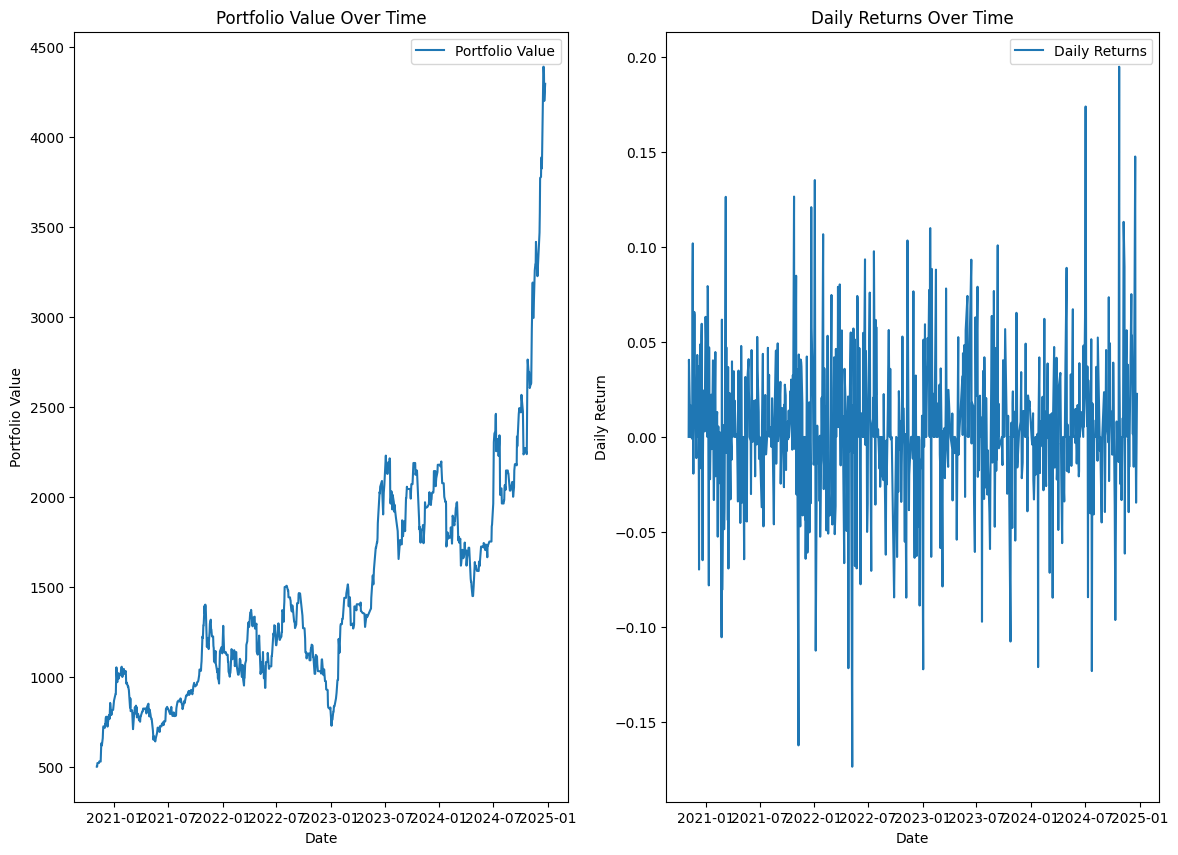

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))

# Portfolio Value over Time
plt.subplot(1, 2, 1)
plt.plot(date, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()

# Daily Returns
plt.subplot(1, 2, 2)
plt.plot(date[1:], daily_returns, label='Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show()

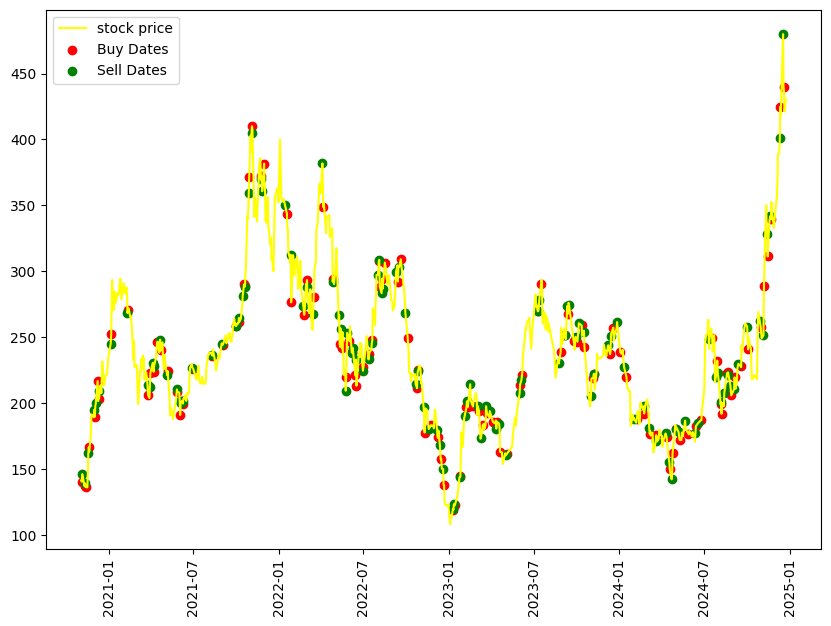

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(date,stock_final_prices,color="yellow",label="stock price")
plt.scatter(buy_time,buy_rate,color='r',label='Buy Dates')
plt.scatter(sell_time,sell_rate,color='g',label='Sell Dates')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

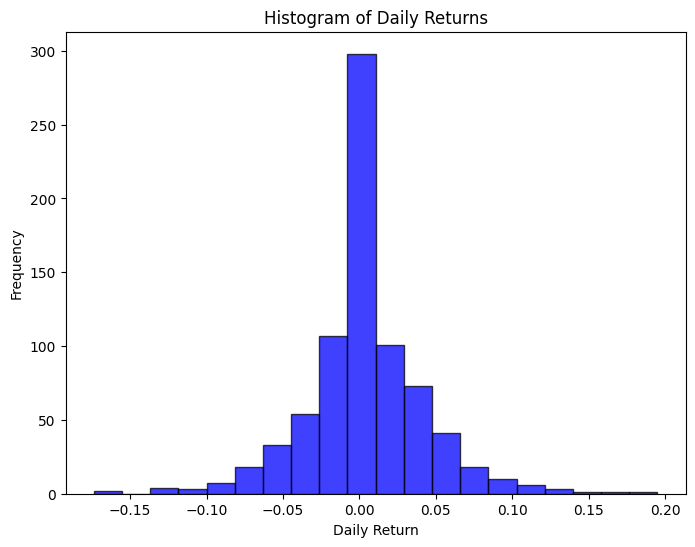

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.show()